In [2]:
jul18 = '/dev/shm/coverage_maps_data_aug_Jul18/'
jul7 = '/dev/shm/coverage_maps_data_aug_Jul7/'
cm_1000_dir = "/home/yl826/3DPathLoss/nc_raytracing/cm_1000_Jul20/"

from os import listdir
from os.path import isfile, join
onlyfiles = [f for f in listdir(jul7) if isfile(join(jul7, f))]

In [ ]:
print(onlyfiles[0:5])

In [3]:
import random


print(random.choice(onlyfiles))

874_1a35d199-3e1c-4ddf-b00f-6c6471dbfb3a_0_0_22.npy


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
building = '/dev/shm/res_plane/Bl_building_npy/'
for i in range(100):
    file = random.choice(onlyfiles)
    print(file)
    res = file.split("_")
    file_ = res[0]+"_"+res[1]+".npy"

    fig = plt.figure()


    ax = plt.subplot(1, 3, 1)
    plt.imshow(((np.load(jul7+file))))
    ax.set_title('Sionna 14')
    plt.colorbar()

    ax = plt.subplot(1, 3, 2)
    plt.imshow(10*np.log10(np.load(jul18+file)))
    ax.set_title('Sionna 15')
    plt.colorbar()
    
    plt.subplot(1, 3, 3)
    plt.imshow(np.load(building+file_))
    plt.colorbar()

    plt.show()

In [ ]:
jul18 = '/dev/shm/coverage_maps_data_aug_Jul18/'
jul7 = '/dev/shm/coverage_maps_data_aug_Jul7/'
cm_1000_dir = "/home/yl826/3DPathLoss/nc_raytracing/cm_1000_Jul20/"
cm_Jul26_test_2e6 = "/home/yl826/3DPathLoss/nc_raytracing/cm_Jul26_test/"
cm_Jul26_test_2e9 = "/home/yl826/3DPathLoss/nc_raytracing/cm_Jul26_test_2e9/"

from os import listdir
from os.path import isfile, join
onlyfiles2 = [f for f in listdir(cm_Jul26_test_2e6) if isfile(join(cm_Jul26_test_2e6, f))]
print(onlyfiles2[0:5])

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

building = '/dev/shm/res_plane/Bl_building_npy/'
fig, ax = plt.subplots(len(onlyfiles2), 3, figsize=(12, len(onlyfiles2)*3))

for i in range(len(onlyfiles2)):
    file = random.choice(onlyfiles2)
    print(file)
    res = file.split("_")
    plt1 = ax[i, 0].imshow(10*np.log10(np.load(cm_Jul26_test_2e6 + file)))
    ax[i, 0].set_title('2e6 samples')
    plt.colorbar(plt1, ax=ax[i, 0])

    plt2 = ax[i, 1].imshow(10*np.log10(np.load(cm_Jul26_test_2e9 + file)))
    ax[i, 1].set_title('2e9 samples')
    plt.colorbar(plt2, ax=ax[i, 1])

    ax[i, 2].imshow(np.load(building + res[0]+'_'+res[1]+'.npy'))

In [ ]:
import random


from os import listdir
from os.path import isfile, join
onlyfiles = [f for f in listdir(jul18) if isfile(join(jul18, f))]

In [66]:
newest_cm_dir = '/home/yl826/3DPathLoss/nc_raytracing/cm_512_Aug10_7e6_isoTx/'
save_pointCloud_dir = '/home/yl826/3DPathLoss/nc_raytracing/cm_512_Aug10_7e6_isoTx_PointCloud/'
building_map_dir = '/home/yl826/res_plane/Bl_building_npy/'

cm_files_newest = [f for f in listdir(newest_cm_dir) if isfile(join(newest_cm_dir, f))]
print(cm_files_newest[0:2])
idx_uuid_list = []
ground_truth_list = []  # list of 128by128 coverage maps
import numpy as np
from tqdm import tqdm


NUM_PIXELS = 128


def get_512by512_slice(loc, arr):
    # get 512*512 slice of arr depending on loc
    if loc[0] < 0 and loc[1] > 0:  # top left
        return arr[0:512, 0:512]
    if loc[0] > 0 and loc[1] > 0:  # top right
        return arr[0:512, 1000-512:]
    if loc[0] < 0 and loc[1] < 0:  # bottom left
        return arr[1000-512:, 0:512]
    if loc[0] > 0 and loc[1] < 0:  # bottom right
        return arr[1000-512:, 1000-512:]


def generate_random_coordinates(num_coordinates, building_map, cm_name):
    b_x, b_y = int(cm_name.split('_')[2]), int(cm_name.split('_')[3])
    b_map_new = get_512by512_slice((b_x, b_y), building_map)
    b_len, _ = b_map_new.shape
    downsampling_rate = int(b_len / NUM_PIXELS)
    assert downsampling_rate == 4, 'downsampling_rate for building map not 4'
    b_map_new = b_map_new[::downsampling_rate, ::downsampling_rate]
    coordinates = []
    while True:  # ensures that no coordinate lies within a building
        r = int(random.uniform(0, NUM_PIXELS-0.00001))
        c = int(random.uniform(0, NUM_PIXELS-0.00001))
        if b_map_new[r, c] < 0.01:
            coordinates.append((r, c))  # row, col
        if len(coordinates) >= 1000:
            break
    return coordinates


def down_sample_ss(center_coord, ground_truth):
    #print(ground_truth)
    path_x = [0,0,1,1,1,-1,-1,-1]
    path_y = [1,-1,0,1,-1,0,1,-1]
    eight_connect_res = []
    for diff_x, diff_y in zip(path_x, path_y):
        tmp_x = int(center_coord[0] + diff_x)
        tmp_y = int(center_coord[1] + diff_y)

        if tmp_x < 128 and tmp_x >= 0 and tmp_y < 128 and tmp_y >= 0:  # ensures no out of boudns
            eight_connect_res.append(ground_truth[tmp_x, tmp_y])
    return np.mean(eight_connect_res)
    

for file in tqdm(cm_files_newest):
    # file = random.choice(onlyfiles)
    idx_uuid = file.split('_')[0] + '_' + file.split('_')[1]
    idx_uuid_list.append(idx_uuid)
    
    ground_truth_arr = 10 * np.log10(np.load(newest_cm_dir + file))
    
    ground_truth_arr[ground_truth_arr == -np.inf] = -160
    ground_truth_arr[ground_truth_arr >= 0] = 0
    ground_truth_arr[ground_truth_arr <= -160] = -160
    
    ground_truth_list.append(ground_truth_arr)
    coordinates = generate_random_coordinates(1000, 
                                              building_map=np.load(building_map_dir + idx_uuid + '.npy'),
                                              cm_name=file)
    res = []
    for point in coordinates:
        res.append(np.array([*point, down_sample_ss(point, ground_truth_arr)]))
    np.save(save_pointCloud_dir + file, np.array(res))

['4907_0110852a-fcfd-475f-bd5a-df624f16cd3e_-244_244_21.npy', '3104_d869858c-5f80-4831-ab48-2102c0077369_-244_-244_22.npy']


100%|█████| 27176/27176 [08:45<00:00, 51.67it/s]


4907_0110852a-fcfd-475f-bd5a-df624f16cd3e_-244_244_21.npy
[[   0.  118. -160.]
 [ 127.  127. -160.]
 [   0.   74. -160.]
 [ 127.  126. -160.]
 [  20.   11. -160.]
 [ 124.  123. -160.]
 [  11.    0. -160.]]
[[ 117.           50.         -130.70343018]
 [  12.            6.         -155.46351624]
 [  72.          116.         -123.48600769]
 [ 122.          126.         -154.12889099]
 [  58.           89.          -85.15693665]]
1000
-160.0


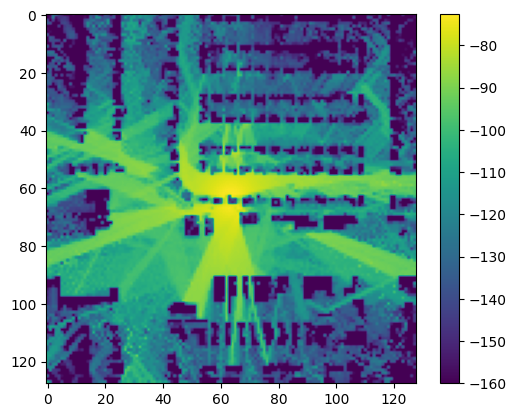

In [65]:
import matplotlib.pyplot as plt
for i, f in enumerate(cm_files_newest[0:2]):
    plt.imshow(ground_truth_list[i])
    print(f)
    # plt.imshow(10*np.log10(np.load(newest_cm_dir + f)))
    plt.colorbar()
    point_cloud = np.load(save_pointCloud_dir + f)
    print(point_cloud[point_cloud[:, -1] == -160, :])
    print(point_cloud[0:5, :])
    print(len(point_cloud))
    print(np.min(np.load(save_pointCloud_dir + f)))
    break

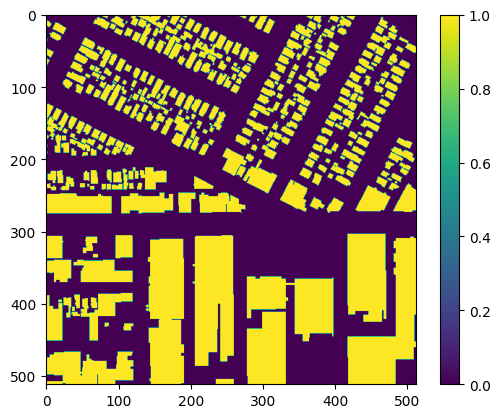

In [58]:
b_map = np.load(building_map_dir + idx_uuid_list[-1] + '.npy')
b_map[b_map > 1] = 1
plt.imshow(get_512by512_slice('tr', b_map))
plt.colorbar()

In [ ]:
from pathlib import Path
import os
import numpy as np
from utils.data_loading_rt import RTDataset
building_height_map_dir = os.path.abspath('/dev/shm/res_plane/Bl_building_npy')
terrain_height_map_dir = os.path.abspath('/dev/shm/res_plane/Bl_terrain_npy')
ground_truth_signal_strength_map_dir = os.path.abspath('/dev/shm/coverage_maps_data_aug_Jul18/')
sparse_ss_dir = Path('/home/yl826/3DPathLoss/nc_raytracing/jul18_sparse')
dataset = RTDataset(building_height_map_dir, terrain_height_map_dir, ground_truth_signal_strength_map_dir, sparse_ss_dir)
dataset.__getitem__(2)['sparse_ss']



In [ ]:
sparse_ss = np.array(dataset.__getitem__(674)['sparse_ss'])
import sys

#np.set_printoptions(threshold=sys.maxsize)
ground_truth = dataset.__getitem__(674)['ground_truth'].numpy()
#print(ground_truth)
print(sparse_ss)
#sparse_ss = np.array(sparse_ss)
print(sparse_ss.shape)
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
sc = ax.scatter(sparse_ss[:,1], sparse_ss[:,0],c=10 * np.log10(sparse_ss[:,2]))
plt.colorbar(sc)
ax.set_ylim(ax.get_ylim()[::-1])        # invert the axis
ax.xaxis.tick_top()                     # and move the X-Axis    

fig2,ax2 = plt.subplots()
plt.imshow(ground_truth)
ax2.xaxis.tick_top()    
plt.colorbar()